# Baseline model using non-network features of Crunchbase

By: Aditya Mengani, Ognjen Sosa, Sanjay Elangovan, Song Park, Sophia Skowronski

**At a snapshot in time, can these features predict inclusion/exclusion in the Pledge 1% community?**

`p1_tag` ~  `rank` + `employee_count` (ordinal) + `country_code` (nominal $\rightarrow$ indicator) + `category_groups_list` (nominal $\rightarrow$ indicator)

### Process Overview
1. Load in data and adjust columns
2. Convert `employee_count` to ordinal scale
3. Convert `country_code` and `category_groups_list` to indicators columns with hashing encoder
4. Filter out rows with missing data
5. Sample non-P1 organizations for the training and test data
6. Model using `LinearRegression`, `KNeighborsClassifier`, `MultinomialNB`, and `LogisticRegression`

**1 CSV file is created from this notebook**:

`df_model` $\rightarrow$ `files/output/baseline.csv`
- Organizations with their `uuid` and model features (listed above plus another `total_fundind_usd`), the encoded `country_code` and `category_groups_list` columns, and 46 indicator columns from the previous notebook.

In [1]:
'''Importing basic data analysis packages'''
import numpy as np
import pandas as pd
import csv
import warnings
import os
import time
import math
import itertools
import statistics
warnings.filterwarnings('ignore')

'''Plotting packages'''
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

'''For Stat'''
import statsmodels.api as sm
from scipy.stats import chi2_contingency

''' For ML'''
import category_encoders as ce
import prince
from sklearn import metrics, svm
from sklearn.linear_model  import LogisticRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB
from sklearn import preprocessing
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100*(start_mem-end_mem)/start_mem))
    return df

ModuleNotFoundError: No module named 'category_encoders'

## Reading in data

In [2]:
df_industry = pd.read_csv('files/output/organizations_by_category_group.csv') # Industry Indicator Columns
df = pd.read_csv('files/output/organizations_merged.csv')

# Merge w/ industry dataframe
df = pd.merge(df, df_industry, how='outer', on='uuid')

print('Starting Dataframe Columns:\n\n{}\n'.format(df.columns.to_list()))

# Convert boolean to binary
df['p1_tag'] = df['p1_tag'].apply(lambda x: 1 if x==True else 0)

# Convert employee_count 'unknown' values to NaN to get accurate missing value count
df['employee_count'] = df['employee_count'].apply(lambda x: np.NaN if x=='unknown' else x)

# Drop irrelevant columns
df_model = df[['uuid', 'p1_tag', 'rank', 'country_code', 'category_groups_list', 'employee_count', 'total_funding_usd',
               'Software', 'Information Technology', 'Internet Services',
               'Data and Analytics', 'Sales and Marketing', 'Media and Entertainment',
               'Commerce and Shopping', 'Financial Services', 'Apps', 'Mobile',
               'Science and Engineering', 'Hardware', 'Health Care', 'Education',
               'Artificial Intelligence', 'Professional Services', 'Design',
               'Community and Lifestyle', 'Real Estate', 'Advertising',
               'Transportation', 'Consumer Electronics', 'Lending and Investments',
               'Sports', 'Travel and Tourism', 'Food and Beverage',
               'Content and Publishing', 'Consumer Goods', 'Privacy and Security',
               'Video', 'Payments', 'Sustainability', 'Events', 'Manufacturing',
               'Clothing and Apparel', 'Administrative Services', 'Music and Audio',
               'Messaging and Telecommunications', 'Energy', 'Platforms', 'Gaming',
               'Government and Military', 'Biotechnology', 'Navigation and Mapping',
               'Agriculture and Farming', 'Natural Resources']]

# Create shorthand for industry columns
industries = ['Software', 'Information Technology', 'Internet Services', 'Data and Analytics',
              'Sales and Marketing', 'Media and Entertainment', 'Commerce and Shopping', 
              'Financial Services', 'Apps', 'Mobile', 'Science and Engineering', 'Hardware',
              'Health Care', 'Education', 'Artificial Intelligence', 'Professional Services', 
              'Design', 'Community and Lifestyle', 'Real Estate', 'Advertising',
              'Transportation', 'Consumer Electronics', 'Lending and Investments',
              'Sports', 'Travel and Tourism', 'Food and Beverage',
              'Content and Publishing', 'Consumer Goods', 'Privacy and Security',
              'Video', 'Payments', 'Sustainability', 'Events', 'Manufacturing',
              'Clothing and Apparel', 'Administrative Services', 'Music and Audio',
              'Messaging and Telecommunications', 'Energy', 'Platforms', 'Gaming',
              'Government and Military', 'Biotechnology', 'Navigation and Mapping',
              'Agriculture and Farming', 'Natural Resources']
industry_map = {industry:'ind_'+str(idx+1) for idx,industry in enumerate(industries)}
df_model = df_model.rename(columns=industry_map)

print('Ending Dataframe Columns:\n\n{}\n'.format(df_model.columns.to_list()))

# Back up columns for encoding
df_model.insert(0, 'country', df_model['country_code'])
df_model.insert(0, 'category_groups', df_model['category_groups_list'])
df_model.insert(0, 'employee_size', df_model['employee_count'])

# Reduce storage for numerical features
df_model = reduce_mem_usage(df_model)

print('\nDataframe shape:', df_model.shape)

del industries, industry_map, df, df_industry

Starting Dataframe Columns:

['uuid', 'name', 'type', 'rank', 'roles', 'country_code', 'region', 'status', 'category_groups_list', 'total_funding_usd', 'founded_on', 'closed_on', 'employee_count', 'primary_role', 'p1_tag', 'p1_date', 'Software', 'Information Technology', 'Internet Services', 'Data and Analytics', 'Sales and Marketing', 'Media and Entertainment', 'Commerce and Shopping', 'Financial Services', 'Apps', 'Mobile', 'Science and Engineering', 'Hardware', 'Health Care', 'Education', 'Artificial Intelligence', 'Professional Services', 'Design', 'Community and Lifestyle', 'Real Estate', 'Advertising', 'Transportation', 'Consumer Electronics', 'Lending and Investments', 'Sports', 'Travel and Tourism', 'Food and Beverage', 'Content and Publishing', 'Consumer Goods', 'Privacy and Security', 'Video', 'Payments', 'Sustainability', 'Events', 'Manufacturing', 'Clothing and Apparel', 'Administrative Services', 'Music and Audio', 'Messaging and Telecommunications', 'Energy', 'Platforms',

## Feature engineering

<a href='https://www.bogotobogo.com/python/scikit-learn/scikit_machine_learning_Data_Preprocessing-Missing-Data-Categorical-Data.php'>scikit-learn : Data Preprocessing I - Missing / categorical data</a>

#### Use ordinal encoding on `employee_count` feature

The column values are truly ordinal (increasing value implies increasing size), so the integer assigned to each value is meaningful.

In [3]:
mapper = [{'col': 'employee_count', 'mapping': {'1-10':1,
                                                '11-50':2,
                                                '51-100':3,
                                                '101-250':4,
                                                '251-500':5,
                                                '501-1000':6,
                                                '1001-5000':7,
                                                '5001-10000':8,
                                                '10000+':9}}]
encoder_ordinal = ce.OrdinalEncoder(cols=['employee_count'], return_df=True, mapping=mapper)
df_model = encoder_ordinal.fit_transform(df_model)
del mapper, encoder_ordinal
df_model[df_model.columns.to_list()[3:-46]].head(3)

,uuid,p1_tag,rank,country_code,category_groups_list,employee_count,total_funding_usd
0,e1393508-30ea-8a36-3f96-dd3226033abd,0,102736.0,USA,"Content and Publishing,Internet Services,Media...",3.0,39750000.0
1,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,0,24985.0,USA,"Information Technology,Internet Services,Priva...",7.0,NaN
2,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,0,9319.0,USA,"Internet Services,Media and Entertainment",3.0,49000000.0


### Dealing with high cardinality of features!

<a href='https://www.analyticsvidhya.com/blog/2020/08/types-of-categorical-data-encoding/'>Here’s All you Need to Know About Encoding Categorical Data (with Python code)</a>
> Summary of Binary versus Hashing encoding

<a href='https://towardsdatascience.com/smarter-ways-to-encode-categorical-data-for-machine-learning-part-1-of-3-6dca2f71b159'>Towards Data Science: Smarter Ways to Encode Categorical Data for Machine Learning</a>

> Better encoding of categorical data can mean better model performance. In this article I’ll introduce you to a wide range of encoding options from the Category Encoders package for use with scikit-learn machine learning in Python.

<a href='https://support.crunchbase.com/hc/en-us/articles/360043146954-What-Industries-are-included-in-Crunchbase-'>What Industries are included in Crunchbase? </a>

> Summary of Crunchbase's 46 Industry Groups

<a href='https://booking.ai/dont-be-tricked-by-the-hashing-trick-192a6aae3087'>Don’t be tricked by the Hashing Trick</a>

> The Hashing Trick is not parameter-free; the hashing space size must be decided beforehand. In this article, the Hashing Trick is described in depth, the effects of different hashing space sizes are illustrated with real world data sets, and a criterion to decide the hashing space size is constructed. If you can choose the hashing space on a per feature basis, use k² for features with less than a thousand categories and 20k for the others.
- If there is only one hashing space and less than twenty thousand features in total, use k², otherwise use n=20k.
- If you want to control for collisions as a proportion r of the features, then use n=k/r.

<a href='https://github.com/MaxHalford/prince#multiple-correspondence-analysis-mca'>MCA</a>

> Multiple correspondence analysis (MCA) is an extension of correspondence analysis (CA). It should be used when you have more than two categorical variables. The idea is simply to compute the one-hot encoded version of a dataset and apply CA on it.

<a href='https://towardsdatascience.com/one-hot-encoding-multicollinearity-and-the-dummy-variable-trap-b5840be3c41a'>One-Hot-Encoding, Multicollinearity and the Dummy Variable Trap</a>

<a href='https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02'>Towards Data Science: All about Categorical Variable Encoding</a>

<img src='https://miro.medium.com/max/1000/0*NBVi7M3sGyiUSyd5.png'>

#### Use hashing encoding on nominal `country_code` feature.

Since there are $210$ unique country codes, we will use `n_components` $\approx 15$

In [4]:
# Create object for hash encoder
n_components = 15
encoder_hash = ce.HashingEncoder(cols='country_code',n_components=n_components)
df_model = encoder_hash.fit_transform(df_model)
del encoder_hash
df_model = df_model.rename(columns={'col_'+str(idx):'country_enc_'+str(idx+1) for idx in range(n_components)})
df_model[df_model.columns.to_list()[:n_components]+df_model.columns.to_list()[n_components+2:-46]].head(3)

,country_enc_1,country_enc_2,country_enc_3,country_enc_4,country_enc_5,country_enc_6,country_enc_7,country_enc_8,country_enc_9,country_enc_10,...,country_enc_13,country_enc_14,country_enc_15,country,uuid,p1_tag,rank,category_groups_list,employee_count,total_funding_usd
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,USA,e1393508-30ea-8a36-3f96-dd3226033abd,0,102736.0,"Content and Publishing,Internet Services,Media...",3.0,39750000.0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,USA,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,0,24985.0,"Information Technology,Internet Services,Priva...",7.0,NaN
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,USA,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,0,9319.0,"Internet Services,Media and Entertainment",3.0,49000000.0


#### Use hashing encoding on nominal industry features from `category_groups_list`? 

`category_groups_list` was already converted to indicator columns in a previous notebook (using one-hot encoding). The one-hot encoder creates a column for each value to compare against all other values. For each column, a row gets a 1 if the row contained that column’s value and a 0 if it did not. This results in 46 columns that can have a value of 1 for multiple columns. Industries can have similar values, so it is likely that there is some correlation between industry types.

We can compare with an alternate model that reduces the 38,379 unique values of `category_groups_list` into the minimal set of columns.

In [5]:
# Create object for hash encoder
n_components = 46
encoder_hash = ce.HashingEncoder(cols='category_groups_list',n_components=n_components)
df_model = encoder_hash.fit_transform(df_model)
del encoder_hash
df_model = df_model.rename(columns={'col_'+str(idx):'ind_enc_'+str(idx+1) for idx in range(n_components)})
df_model[df_model.columns.to_list()[:-46]].head(3)

,ind_enc_1,ind_enc_2,ind_enc_3,ind_enc_4,ind_enc_5,ind_enc_6,ind_enc_7,ind_enc_8,ind_enc_9,ind_enc_10,...,country_enc_14,country_enc_15,employee_size,category_groups,country,uuid,p1_tag,rank,employee_count,total_funding_usd
0,0,0,0,0,0,0,0,0,0,1,...,0,0,51-100,"Content and Publishing,Internet Services,Media...",USA,e1393508-30ea-8a36-3f96-dd3226033abd,0,102736.0,3.0,39750000.0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,1001-5000,"Information Technology,Internet Services,Priva...",USA,bf4d7b0e-b34d-2fd8-d292-6049c4f7efc7,0,24985.0,7.0,NaN
2,0,0,1,0,0,0,0,0,0,0,...,0,0,51-100,"Internet Services,Media and Entertainment",USA,5f2b40b8-d1b3-d323-d81a-b7a8e89553d0,0,9319.0,3.0,49000000.0


In [6]:
# Save to CSV
print('Model shape:', df_model.shape)
df_model.to_csv('files/output/baseline.csv', index=False, sep=';')
print('OUTPUT df_model TO CSV `files/output/baseline.csv`')

Model shape: (1131326, 115)
OUTPUT TO CSV `files/output/baseline.csv`


## Dealing with missing data -- remove (for now)

Remove rows with missing `category_groups_list`, `employee_size`, `country_code` and `rank` values

In [7]:
df_num_missing = df_model[['rank', 'country', 'category_groups', 'employee_size']].isna().sum()/len(df_model)
output_string = df_num_missing.to_string(float_format=lambda x: '{:.2f}%'.format(x*100))
print('BEFORE...\n')
print('MISSING VALUES BY PERCENTAGE\n')
print(output_string)

df_model=df_model[~df_model.category_groups.isna() & 
                  ~df_model.employee_size.isna()  & 
                  ~df_model.country.isna() & 
                  ~df_model['rank'].isna() ]
df_num_missing = df_model[['rank', 'country', 'category_groups', 'employee_size']].isna().sum()/len(df_model)
output_string = df_num_missing.to_string(float_format=lambda x: '{:.2f}%'.format(x*100))
print('\nAFTER...\n')
print('MISSING VALUES BY PERCENTAGE\n')
print(output_string)
del output_string, df_num_missing

BEFORE...

MISSING VALUES BY PERCENTAGE

rank               4.13%
country           17.04%
category_groups    8.72%
employee_size     27.58%

AFTER...

MISSING VALUES BY PERCENTAGE

rank              0.00%
country           0.00%
category_groups   0.00%
employee_size     0.00%


# Baseline model

#### Select equal sample of non-Pledge 1% organizations

<a href='https://cmdlinetips.com/2018/02/how-to-randomly-select-rows-in-pandas-pandas-tutorial/'>How To Randomly Select Rows in Pandas?</a>

In [8]:
df_model_p1 = df_model[df_model['p1_tag']==1]
df_model_cb = df_model[df_model['p1_tag']==0].sample(n=df_model_p1.shape[0], replace=False)
df_model_baseline = pd.concat([df_model_p1, df_model_cb]).reset_index(drop=True)
df_model_baseline = reduce_mem_usage(df_model_baseline)
print('Baseline model shape:', df_model_baseline.shape)

Mem. usage decreased to  2.27 Mb (70.2% reduction)
Baseline model shape: (12134, 115)


### Correlation matrix with numeric variables

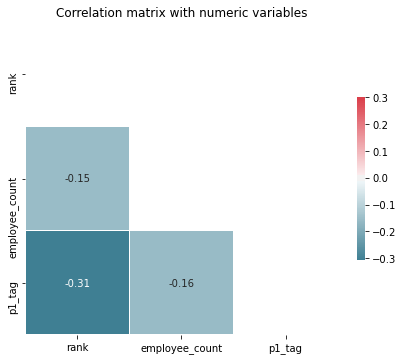

In [9]:
'''Correlation with numeric variables'''
# Compute the correlation matrix
cols = ['rank', 'employee_count', 'p1_tag']
corr = df_model_baseline[cols].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)
plt.title('Correlation matrix with numeric variables')
plt.show()

### Cramer's V correlation matrix for categorical variables

<a href='https://stackoverflow.com/questions/51859894/how-to-plot-a-cramer-s-v-heatmap-for-categorical-features'>Stack overflow</a>

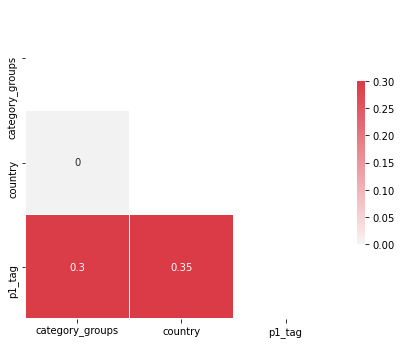

In [10]:
'''Correlation with categorical variables'''
def cramers_corrected_stat(confusion_matrix):
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

# Compute the correlation matrix
cols = ['category_groups', 'country', 'p1_tag']
corrM = np.zeros((len(cols),len(cols)))

for col1, col2 in itertools.combinations(cols, 2):
    idx1, idx2 = cols.index(col1), cols.index(col2)
    corrM[idx1, idx2] = cramers_corrected_stat(pd.crosstab(df_model_baseline[col1], df_model_baseline[col2]))
    corrM[idx2, idx1] = corrM[idx1, idx2]
    
# Compute the correlation matrix
corr2 = pd.DataFrame(corrM, index=cols, columns=cols)

# Generate a mask for the upper triangle
mask = np.zeros_like(corr2, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr2, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

### Split data into training and test 

In [11]:
# Drop unusable columns
df_model_baseline = df_model_baseline.drop(['uuid','category_groups','country','employee_size','total_funding_usd'], axis=1)
df_model_baseline = df_model_baseline.drop(df_model_baseline.columns.to_list()[-46:], axis=1)

# Split dataframe into X and y
df_model_baseline_X = df_model_baseline.loc[:,~df_model_baseline.columns.isin(['p1_tag'])]
df_model_baseline_y = df_model_baseline.loc[:,df_model_baseline.columns.isin(['p1_tag'])]

# spliting the clean dataset into 70/30 for training/ test
X_train, X_test, y_train, y_test = train_test_split(df_model_baseline_X, df_model_baseline_y, test_size=0.3, random_state=1)

print('training data shape:', X_train.shape)
print('train label shape:', y_train.shape)
print('tes data shape:',  X_test.shape)
print('test label shape:', y_test.shape)

training data shape: (8493, 63)
train label shape: (8493, 1)
tes data shape: (3641, 63)
test label shape: (3641, 1)


### Linear regression with `LinearRegression`

In [12]:
# Training model using linear regression
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

# Predicting y 
y_pred = regressor.predict(X_test)

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
print('R2 Score:', r2_score(y_test, y_pred))
print('Score:', regressor.score(X_test, y_test))


Mean Absolute Error: 0.41316518
Mean Squared Error: 0.20658746
Root Mean Squared Error: 0.45451894
R2 Score: 0.17317808413229996
Score: 0.17317808413229996


### K-Nearest Neighbor with `KNeighborsClassifier`

In [13]:
k_values = {'n_neighbors': np.arange(1,29,2)}
KNN_cross_val = GridSearchCV(KNeighborsClassifier(), param_grid=k_values, scoring='accuracy')
KNN_cross_val.fit(X_train, y_train)
print(KNN_cross_val.best_params_)

KNN = KNeighborsClassifier(n_neighbors=KNN_cross_val.best_params_['n_neighbors'])
KNN.fit(X_train, y_train)
y_pred = KNN.predict(X_test)
num_wrong = sum(y_test.values.reshape(len(y_test)) != y_pred)
print('k={}: Number misclassified ... {} out of {}'.format(KNN_cross_val.best_params_['n_neighbors'], num_wrong, len(y_test)))
print('Accuracy score:', KNN.score(X_test, y_test))

{'n_neighbors': 27}
k=27: Number misclassified ... 1392 out of 3641
Accuracy score: 0.6176874485031585


### Naive Bayes with `MultinomialNB`

In [14]:
alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
NB_cross_val = GridSearchCV(MultinomialNB(), param_grid=alphas, scoring='accuracy')
NB_cross_val.fit(X_train, y_train)
print(NB_cross_val.best_params_)

NB = MultinomialNB(alpha=NB_cross_val.best_params_['alpha'])
NB.fit(X_train, y_train)
print('Accuracy score:', NB.score(X_test, y_test))

{'alpha': 10.0}
Accuracy score: 0.6262015929689646


### Logistic Regression with `LogisticRegression`

In [15]:
Cs = {'C': [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0, 10.0, 20.0]}
LR_cross_val = GridSearchCV(LogisticRegression(), param_grid=Cs, scoring='accuracy')
LR_cross_val.fit(X_train, y_train)
print(LR_cross_val.best_params_)

LR = LogisticRegression(C=LR_cross_val.best_params_['C'])
LR.fit(X_train, y_train)
print('Accuracy score:', LR.score(X_test, y_test))

{'C': 0.0001}
Accuracy score: 0.4880527327657237



### Bootstrapping model running for 100 iterations to calculate the average of accuracy scores

In [17]:
# Define lists to capture different accuracies
Linear_scores = []
NB_scores = []
KNN_scores = []
LR_scores = []

print('\n*************** Beginning of 100 iterations ***************')    
for i in range(100):
    
    df_model_p1 = df_model[df_model['p1_tag']==1]
    df_model_cb = df_model[df_model['p1_tag']==0].sample(n=df_model_p1.shape[0], replace=False)
    df_model_baseline = pd.concat([df_model_p1, df_model_cb]).reset_index(drop=True)
    df_model_baseline = df_model_baseline.drop(['uuid','category_groups','country','employee_size','total_funding_usd'], axis=1)
    df_model_baseline_X = df_model_baseline.loc[:,~df_model_baseline.columns.isin(['p1_tag'])]
    df_model_baseline_y = df_model_baseline.loc[:,df_model_baseline.columns.isin(['p1_tag'])]

    # spliting the clean dataset into 70/30 for training/ test
    # Removed random_state=1 to avoid seeding so that we can get random results in each iteration
    X_train, X_test, y_train, y_test = train_test_split(df_model_baseline_X, df_model_baseline_y, test_size=0.3)
    
    # Linear regression
    regressor = LinearRegression()  
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    Linear_scores.append(r2_score(y_test, y_pred))
    
    # Naive Bayes
    NB = MultinomialNB(alpha=10)
    NB.fit(X_train, y_train)
    NB_scores.append(NB.score(X_test, y_test))
    
    # K-Nearest Neighbor
    KNN = KNeighborsClassifier(n_neighbors=27)
    KNN.fit(X_train, y_train)
    KNN_scores.append(KNN.score(X_test, y_test))
    
    # Logistic Regression
    LR = LogisticRegression(C=0.0001)
    LR.fit(X_train, y_train)
    LR_scores.append(LR.score(X_test, y_test))
    
    print('The currrent iteration is ',str(i+1))

print('\n*************** End of 100 iterations ***************')    
print('Averaged Logistic Regression accuracy Score:', round(statistics.mean(LR_scores),4))
print('Averaged Linear Regression accuracy score:', round(statistics.mean(Linear_scores),4))
print('Averaged K-Nearest Neighbour accuracy score:', round(statistics.mean(KNN_scores),4))
print('Averaged Naive Bayes accuracy score:', round(statistics.mean(NB_scores),4))


*************** Beginning of 100 iterations ***************
The currrent iteration is  1
The currrent iteration is  2
The currrent iteration is  3
The currrent iteration is  4
The currrent iteration is  5
The currrent iteration is  6
The currrent iteration is  7
The currrent iteration is  8
The currrent iteration is  9
The currrent iteration is  10
The currrent iteration is  11
The currrent iteration is  12
The currrent iteration is  13
The currrent iteration is  14
The currrent iteration is  15
The currrent iteration is  16
The currrent iteration is  17
The currrent iteration is  18
The currrent iteration is  19
The currrent iteration is  20
The currrent iteration is  21
The currrent iteration is  22
The currrent iteration is  23
The currrent iteration is  24
The currrent iteration is  25
The currrent iteration is  26
The currrent iteration is  27
The currrent iteration is  28
The currrent iteration is  29
The currrent iteration is  30
The currrent iteration is  31
The currrent itera